# Computataional Neuroscience

PSYC B265, Fall 2025

This lab is based on Trappenberg Chapter 7.2.4. MLP with keras

## Setup colab notebook

Import packages.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

For today's lab, we will also use `tensorflow` and `keras` packages to run neural networks.

In [11]:
import tensorflow as tf
from keras import models, layers, optimizers, datasets, utils

## Multilayer Perceptron (MLP) with `keras`

A deep neural network here is simply a network that has several layers. We can use this to finally return to the example of recognizing hand-written digits. In particular, we will use the famous MNIST (Modified National Institute of Standards and Technology) database that has driven a lot of developments in deep learning. The data set consists of digitized examples of hand-written numbers from 0 to 9. Each image consist of 28*28 pixels.

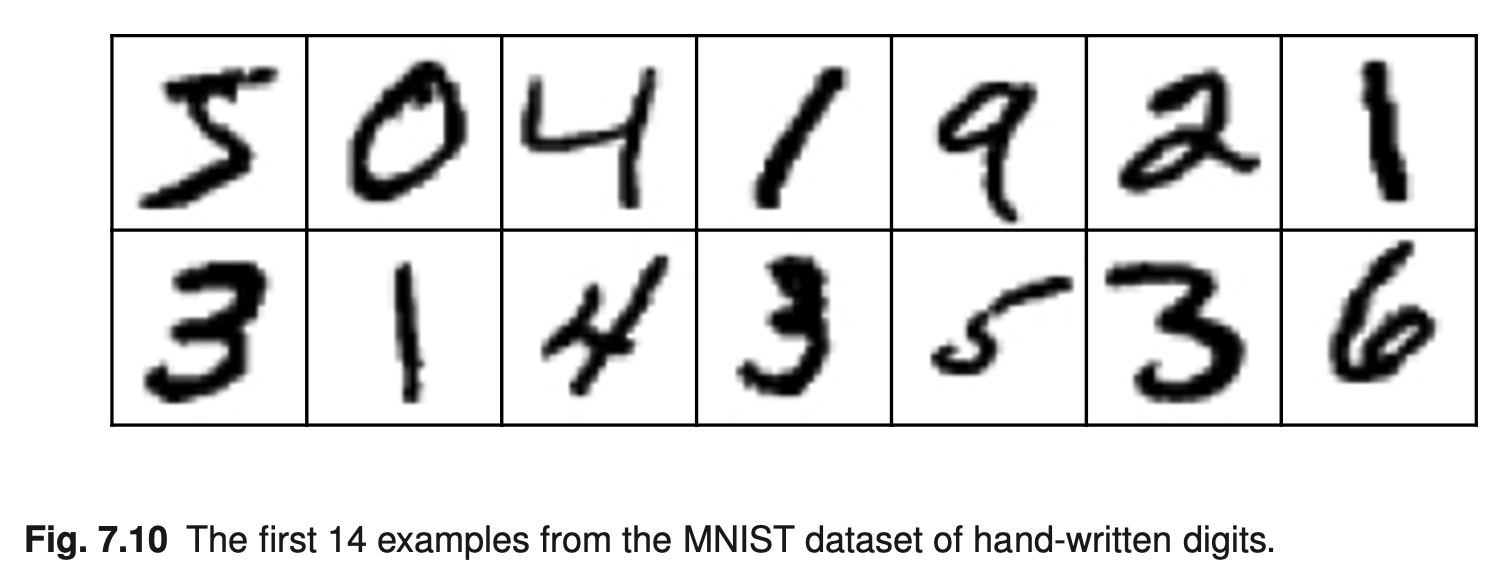

### Part 1. preprocessing

We will load data from MNIST dataset and divide it into two sets: train and test. Train data will be used to update the weights, and test data will be set aside to evaluate the model after all training is done. Each set has input (`x`) and output (`y`).


In [4]:
# load train and test data for mnist dataset.
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
# x is input, y is output

# check shape of the dataset
print(f'x training {x_train.shape} test {x_test.shape}')
print(f'y training {y_train.shape} test {y_test.shape}')

x training (60000, 28, 28) test (10000, 28, 28)
y training (60000,) test (10000,)


In [5]:
# print unique values of output labels
print(f'unique output labels {set(np.concatenate([y_train, y_test]))}')

unique output labels {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)}


We will show the first sample (data) in the training dataset using [`plt.matshow`](https://matplotlib.org/stable/gallery/images_contours_and_fields/matshow.html#sphx-glr-gallery-images-contours-and-fields-matshow-py).

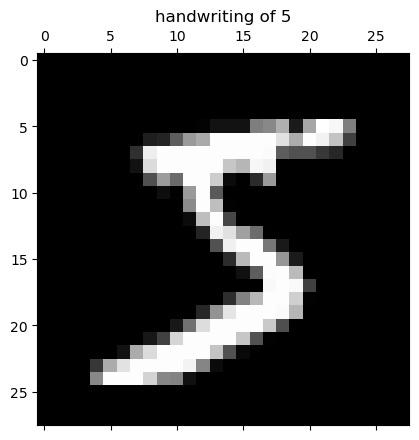

In [6]:
# show the first sample
plt.matshow(x_train[0, :], cmap='gray')
plt.title(f'handwriting of {y_train[0]}')
plt.show()

We will need to prepare the data in the appropriate format.

We will also rescale the 256 bits grayscale input images so the maximum value is 1. This rescaling make training more stable and efficient by ensuring all inputs are on a similar scale to a range of [0, 1]. [Why? Watch 1:17-1:55](https://www.youtube.com/watch?v=bxe2T-V8XRs&t=77s)

In [12]:
x_train = x_train/255
x_test = x_test/255

We need to gather all the pixels in the image into a 1-dimensional vector so the model to process each pixel as an input feature (i.e., one input neuron will process one pixel of the image). We will reshape the image into a large vector of size 784 (= 28 x 28).

In [13]:
x_train_reshaped = x_train.reshape(60000, 28*28)
x_test_reshaped = x_test.reshape(10000, 28*28)

In [14]:
x_train_reshaped # 0 values correspond to background, 0-1 corresponds to written area

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(60000, 784))

Also, we change the labels into a 1-hot representation which is vector of length equal to the number of classes with zeros in all components except the position that indicates the label of this class. For example, with three classes we could have 1 → [1, 0, 0], 2 → [0, 1, 0], 3 → [0, 0, 1]. We can use the Keras function to categorical() for this purpose.

In [15]:
# as the outputs have 10 categories, represent them as 10 binary output units
y_bin_train = utils.to_categorical(y_train, 10)
y_bin_test = utils.to_categorical(y_test, 10)

print(f'{y_train[0]}: {y_bin_train[0]}')
# created expected output vector

5: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Part 2. configure the neural network

We will configure a feedforward neural network with 4 layers in total, including 2 hidden layers. Each hidden layer will contain 16 units. In this setup, there are no "recurrent" connections (i.e., no feedback loop a neuron synapses onto lateral or previous layers) -- hence, *feedforward*. Information only flows forward from input to output as the neural network generates a prediction.

The MLP is characterized by a fully connected layer where each neuron of the previous layer is connected to every neuron in the receiving layer. Such layers are now commonly called dense layers.

The hidden layers will use rectified linear unit (reLU) activation function, which resembles the f-I curve. The output layer will use softmax activation function -- similar to the sigmoid function used for binary decisions but extended to handle more than 2 categories or classes, as in our digit-classification problem.

In [16]:
# set up input layer 'inputs'
# set the input shape to match the flattened image size
inputs = layers.Input(shape = (784,))

# set up the hidden layers
hidden1 = layers.Dense(16, activation='relu')(inputs) # dense = fully connected
hidden2 = layers.Dense(16, activation='relu')(hidden1)

# set up the output layer 'outputs'
outputs = layers.Dense(10, activation='softmax')(hidden2)
# binary decisions, relaxed for multiple classes

# create the neural network model with input and output layers
# by connecting the 'inputs' and 'outputs' layers that are set above.
model = models.Model(inputs=inputs, outputs=outputs)

In the `compile` step, we will configure how to train the classifier by specifying which loss function to use, which optimizer we will use, and also which metric we use to evaluate the results. For now, we want to show that such networks with these popular choices for optimizer and loss function can do remarkably well.

In [17]:
# configure how to train the classifier:
# specify the optimizer, loss function, and performance metrics
model.compile(optimizer='Nadam',
              loss='categorical_crossentropy', metrics=['accuracy'])

### Part 3. training

Now we will feed the model with the training data (the vectorized pixels and the labels). A few more decisions here:
* batch size: how many samples will the network see before it updates weights?
* epochs: how many times will the entire sample be seen by the network?
* validation split: it is very instructive and important for the development of the models to monitor the performance of the model during learning. To make sure that the model isn't overfitting, we've already set aside test data. In addition to the test data, we will reserve a portion of the training data as a "validation" set. This data not be used to update weights; instead, we will use it to monitor model performance across training epochs.

Set random seed for reproducibility. Setting the same "seed" ensures that anyone who runs this code will get the same results.

In [18]:
# set random seed for reproducibility
tf.random.set_seed(12345)

In [19]:
# fit the model and store the history in the variable 'history'
history = model.fit(x_train_reshaped, y_bin_train,
                    batch_size=128, epochs=10,
                    validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2906 - loss: 2.0629 - val_accuracy: 0.5003 - val_loss: 1.6183
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5952 - loss: 1.3017 - val_accuracy: 0.6808 - val_loss: 1.0383
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6941 - loss: 0.9580 - val_accuracy: 0.7318 - val_loss: 0.8469
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7324 - loss: 0.8352 - val_accuracy: 0.7627 - val_loss: 0.7621
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7584 - loss: 0.7670 - val_accuracy: 0.7867 - val_loss: 0.7039
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7799 - loss: 0.7124 - val_accuracy: 0.8055 - val_loss: 0.6524
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7987 - loss: 0.6619 - val_accuracy: 0.8244 - val_loss: 0.6045
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8160 - loss: 0.6147 - val_accuracy: 0.

### Part 4. evaluation

We will plot model performance.

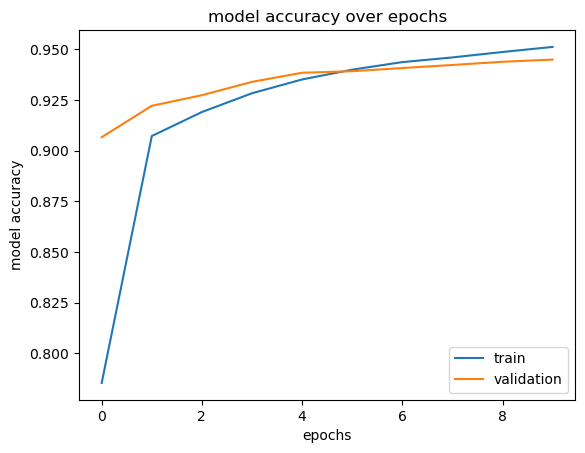

In [18]:
# plot the accuracy over training epochs (iterations)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('model accuracy over epochs')
plt.legend(loc='lower right')

# label x-axis and y-axis
plt.xlabel("epochs")
plt.ylabel("model accuracy")

plt.show()

We will also plot loss over training epochs.

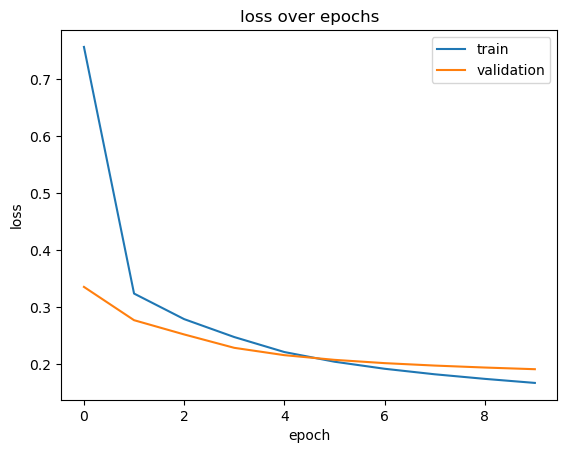

In [20]:
# plot the loss (error) over training epochs (iterations)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('loss over epochs')
plt.legend(loc='upper right')

# label x-axis and y-axis
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

Finally, we will test the model performance for unseen data.

In [23]:
# evaluate with test set
score = model.evaluate(x_test_reshaped, y_bin_test)
print(f'test set loss: {score[0]*100:0.1f}% accuracy: {score[1]*100:0.1f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.9436 - loss: 0.1907
test set loss: 19.1% accuracy: 94.4%


We will now give some test images and see what the model predicts.

In [24]:
y_predicted = model.predict(x_test_reshaped)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


In [25]:
def show_prediction(i):
    plt.matshow(x_test_reshaped[i,:].reshape(28,28), cmap='gray')
    plt.title(f'correct label {y_test[i]} predicted {y_predicted[i].argmax()}')
    plt.show()
    plt.bar(range(10), y_predicted[i])
    plt.xlabel('label')
    plt.ylabel('p(label)')

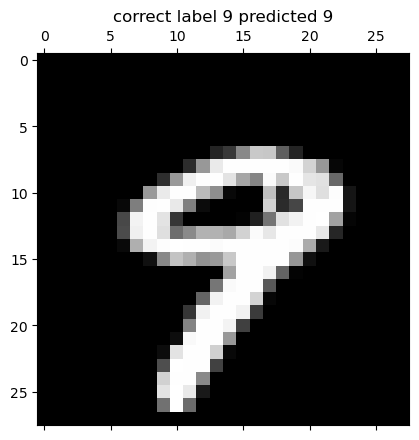

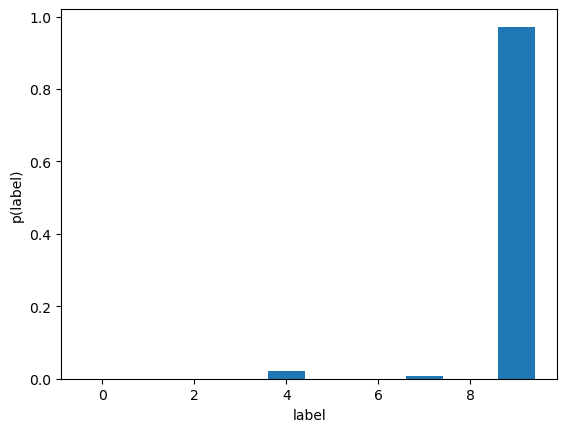

In [27]:
show_prediction(np.where(y_test==9)[0][1])

## Exercise

#### TODO:

Try different numbers of hidden layers and different numbers of units in the layers. 
I am going to test the model with 
* 3 hidden layers, keeping number of units per layer constant
* 4 units per layer, keeping the number of layers constant

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7188 - loss: 0.8717 - val_accuracy: 0.8939 - val_loss: 0.3654
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9045 - loss: 0.3338 - val_accuracy: 0.9211 - val_loss: 0.2774
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9211 - loss: 0.2743 - val_accuracy: 0.9335 - val_loss: 0.2406
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9302 - loss: 0.2429 - val_accuracy: 0.9385 - val_loss: 0.2218
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9365 - loss: 0.2230 - val_accuracy: 0.9421 - val_loss: 0.2107
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9408 - loss: 0.2081 - val_accuracy: 0.9448 - val_loss: 0.2030
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9442 - loss: 0.1960 - val_accuracy: 0.9456 - val_loss: 0.1967
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9466 - loss: 0.1857 - val_accuracy: 0.

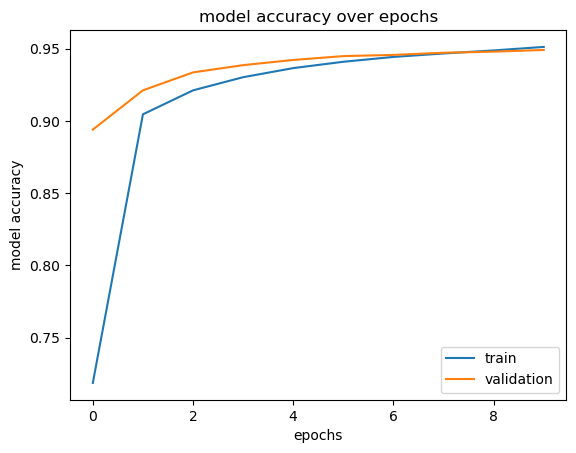

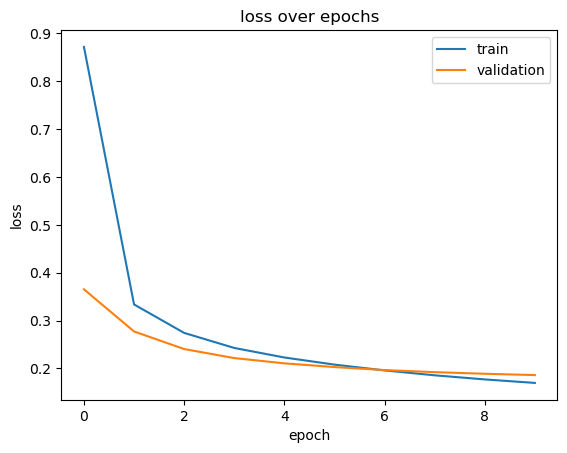

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.9438 - loss: 0.1885
test set loss: 18.8% accuracy: 94.4%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


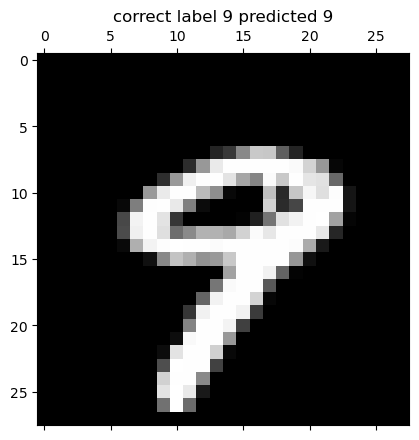

Text(0, 0.5, 'p(label)')

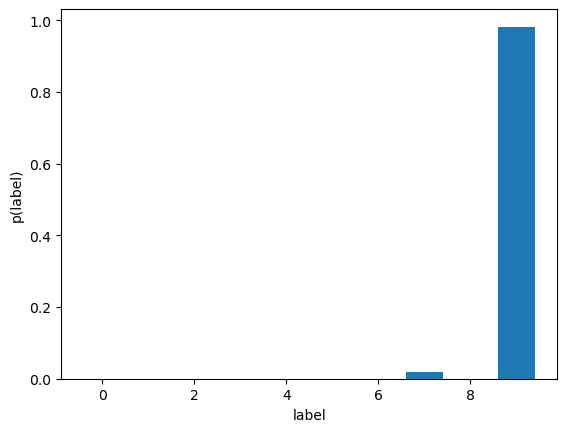

In [10]:
## Build Neural Network 1: Third Hidden Layer

# set up input layer 'inputs'
# set the input shape to match the flattened image size
inputs1 = layers.Input(shape = (784,))

# set up the hidden layers
hidden1 = layers.Dense(16, activation='relu')(inputs1) # dense = fully connected
hidden2 = layers.Dense(16, activation='relu')(hidden1)
hidden3 = layers.Dense(16, activation='relu')(hidden2)

# set up the output layer 'outputs'
outputs1 = layers.Dense(10, activation='softmax')(hidden3)
# binary decisions, relaxed for multiple classes

# create the neural network model with input and output layers
# by connecting the 'inputs' and 'outputs' layers that are set above.
model1 = models.Model(inputs=inputs1, outputs=outputs1)

# configure how to train the classifier:
# specify the optimizer, loss function, and performance metrics
model1.compile(optimizer='Nadam',
              loss='categorical_crossentropy', metrics=['accuracy'])

# set a random seed to reproduce results
tf.random.set_seed(12345)

# fit the model and store the history in the variable 'history'
history1 = model1.fit(x_train_reshaped, y_bin_train,
                    batch_size=128, epochs=10,
                    validation_split=0.2)

## Plot Accuracy

plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='validation')
plt.title('model accuracy over epochs')
plt.legend(loc='lower right')

# label x-axis and y-axis
plt.xlabel("epochs")
plt.ylabel("model accuracy")

plt.show()

## Plot Loss

# plot the loss (error) over training epochs (iterations)
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='validation')
plt.title('loss over epochs')
plt.legend(loc='upper right')

# label x-axis and y-axis
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

## Testing on new data

# calculate accuracy on test set
score1 = model1.evaluate(x_test_reshaped, y_bin_test)
print(f'test set loss: {score1[0]*100:0.1f}% accuracy: {score1[1]*100:0.1f}%')

# store predicted digits in y_predicted variable
y_predicted1 = model1.predict(x_test_reshaped)

# pick an entry and see if neural network correctly classified

plt.matshow(x_test_reshaped[np.where(y_test==9)[0][1],:].reshape(28,28), cmap='gray')
plt.title(f'correct label {y_test[np.where(y_test==9)[0][1]]} predicted {y_predicted1[np.where(y_test==9)[0][1]].argmax()}')
plt.show()
plt.bar(range(10), y_predicted1[np.where(y_test==9)[0][1]])
plt.xlabel('label')
plt.ylabel('p(label)')

With three layers, the accuracy was higher on the training data than the validation, which tells me this model isn't overfit. I honestly don't see much of a difference between using 2 vs. 3 layers, which makes me think 2 is the better option as it has less computational intensity. Even the accuracy in classifyng the "9" is quite similar. 

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4325 - loss: 1.8353 - val_accuracy: 0.6289 - val_loss: 1.1864
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7035 - loss: 0.9414 - val_accuracy: 0.7763 - val_loss: 0.7494
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7910 - loss: 0.6876 - val_accuracy: 0.8382 - val_loss: 0.5832
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8386 - loss: 0.5553 - val_accuracy: 0.8692 - val_loss: 0.4800
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8642 - loss: 0.4757 - val_accuracy: 0.8816 - val_loss: 0.4238
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8764 - loss: 0.4314 - val_accuracy: 0.8894 - val_loss: 0.3916
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8846 - loss: 0.4039 - val_accuracy: 0.8946 - val_loss: 0.3705
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8908 - loss: 0.3841 - val_accuracy: 0.

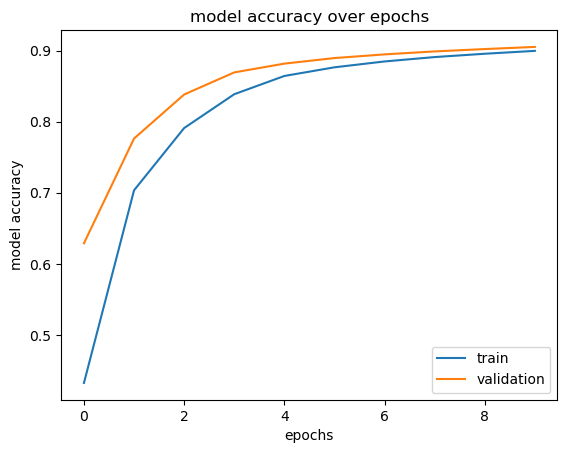

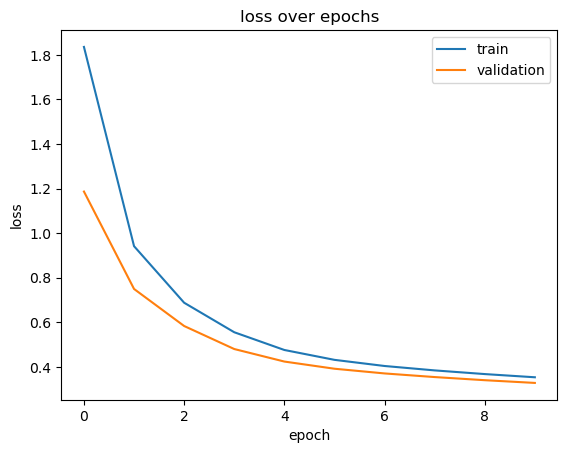

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.9036 - loss: 0.3393
test set loss: 33.9% accuracy: 90.4%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step


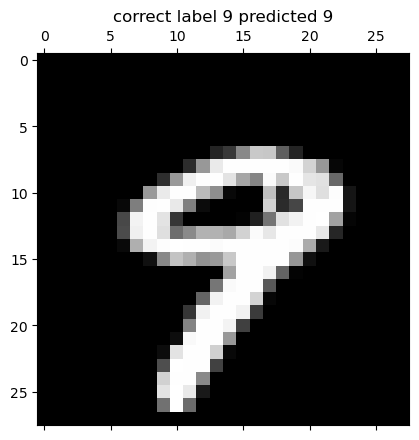

Text(0, 0.5, 'p(label)')

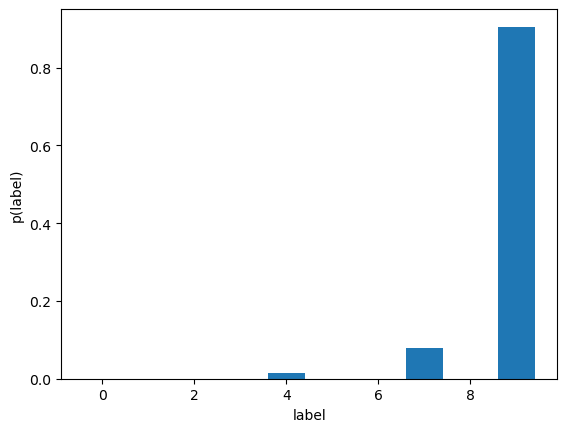

In [20]:
## Build Neural Network 1: Fewer neurons at each layer

# set up input layer 'inputs'
# set the input shape to match the flattened image size
inputs2 = layers.Input(shape = (784,))

# set up the hidden layers
hidden1 = layers.Dense(32, activation='relu')(inputs2) # dense = fully connected
hidden2 = layers.Dense(32, activation='relu')(hidden1)

# set up the output layer 'outputs'
outputs2 = layers.Dense(10, activation='softmax')(hidden2)
# binary decisions, relaxed for multiple classes

# create the neural network model with input and output layers
# by connecting the 'inputs' and 'outputs' layers that are set above.
model2 = models.Model(inputs=inputs2, outputs=outputs2)

# configure how to train the classifier:
# specify the optimizer, loss function, and performance metrics
model2.compile(optimizer='Nadam',
              loss='categorical_crossentropy', metrics=['accuracy'])

# set a random seed to reproduce results
tf.random.set_seed(12345)

# fit the model and store the history in the variable 'history'
history2 = model2.fit(x_train_reshaped, y_bin_train,
                    batch_size=128, epochs=10,
                    validation_split=0.2)

## Plot Accuracy

plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.title('model accuracy over epochs')
plt.legend(loc='lower right')

# label x-axis and y-axis
plt.xlabel("epochs")
plt.ylabel("model accuracy")

plt.show()

## Plot Loss

# plot the loss (error) over training epochs (iterations)
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.title('loss over epochs')
plt.legend(loc='upper right')

# label x-axis and y-axis
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

## Testing on new data

# calculate accuracy on test set
score2 = model2.evaluate(x_test_reshaped, y_bin_test)
print(f'test set loss: {score2[0]*100:0.1f}% accuracy: {score2[1]*100:0.1f}%')

# store predicted digits in y_predicted variable
y_predicted2 = model2.predict(x_test_reshaped)

# pick an entry and see if neural network correctly classified

plt.matshow(x_test_reshaped[np.where(y_test==9)[0][1],:].reshape(28,28), cmap='gray')
plt.title(f'correct label {y_test[np.where(y_test==9)[0][1]]} predicted {y_predicted2[np.where(y_test==9)[0][1]].argmax()}')
plt.show()
plt.bar(range(10), y_predicted2[np.where(y_test==9)[0][1]])
plt.xlabel('label')
plt.ylabel('p(label)')

#### TODO: 

Describe your network. How many hidden layers do you have? How many weights are being optimized? 
> I built two neural networks: one with an extra hidden layer (3 total) and the same number of units per layer (16), and one with the same number of hidden layers (2 total) and double the number of units per layer (32). Call these M1 and M2, respectively. In M1, $16\times 3 = 48$ weights are being optimized, whereas in M2, $32\times 2 = 64$ weights are being optimized.

Discuss how your network performed, including any signs of overfitting. 
> M1 performed very similarly to our original model (16 units per layer for 2 layers), with test set loss of 18.8% and accuracy of 94.4% (rel. original model test set loss: 19.1% accuracy: 94.4%). The plots of loss & accuracy over time were also very similar. This tells me that using 2 layers is better for this dataset than using 3, as we didn't see a significant improvement after increasing computational efficiency.
> M2 performed much worse than the original model, with test set loss of 33.9% and accuracy 90.4% -- that's a 14.8% increase in error and a 4% decrease in accuracy, relative to the original model. What surprises me is that this model is not overfit, as the train accuracy is not significantly higher than the validation accuracy. In fact, M2 is the only model where the train accuracy is completely less than the validation accuracy. Maybe it needs more epochs to properly tune all of the weights? I doubt that's the case since the accuracy & loss flattened out by the last few rounds.

Discuss the implications for a biological neural network that learns the synaptic weights from experiences.

> 1. Using more neurons and more layers takes energy (which we saw in runtime) - minimizing the number of layers and input units per layer is more efficient both for computer and the brain. A biological neural network will then use as few neurons and layers as possible to accomplish the desired task in the most efficient way. Little improvements in performance aren't worth huge amounts of energy.
> 2. Different datasets (new experiences) better help the neural network learn. If the training data was all 1's or 2's, the network would have difficulty identifying the difference between a 7 and an 8. Similarly to a biological neural network, new experiences better help the network decide which neurons produce the desired output and adjust weights accordingly.

## Great work today!

Write your name below and copy this file to `submissions/lab5_MLP/` folder. Submission closes at midnight tonight. 

Note that file name should be the same as the original (`lab5_MLP.ipynb`).

### Name: Suzanna Semaan

<div class="alert alert-block alert-info">
    <b>Grade:</b> 5/5 <br>
</div>